In [1]:
import pandas as pd
import os
import re

from geopy.geocoders import Nominatim
# from transformers import BertTokenizer, BertModel
from tqdm.notebook import tqdm

import torch
import torch.nn as nn

from torch.optim import Adam

from torch.utils.data import DataLoader, Dataset
from transformers import BertModel, BertTokenizer
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from IPython.display import clear_output
from sklearn.metrics import f1_score, accuracy_score

import sys
sys.path.append('../')

from datasets import CustomMetricLearningDataset
from models import CountryEncoder

In [4]:
data = pd.read_csv('../data/geotexts_data_clean.csv')

C:\Users\kazza\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [5]:
#use multilingual bert
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
encoder = BertModel.from_pretrained("bert-base-multilingual-cased")

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
#add gradient dropout for tuning bert
!git clone https://github.com/PKUnlp-icler/ChildTuning.git

Cloning into 'ChildTuning'...


In [7]:
data

,text,latitude,longitude,coord_pair,country,city,clean_text,lengths
0,"@Mafercoronelq Ese mal hay en todo el país, sa...",-0.033244,-75.452309,"-0.0332440668675476,-75.45230903823258",Colombia,NaN,mafercoronelq ese mal hay en todo el país sale...,12
1,Qué hijueputa falta me hace visitar una librería.,-0.033244,-75.452309,"-0.0332440668675476,-75.45230903823258",Colombia,NaN,qué hijueputa falta me hace visitar una librería,8
2,¡Echa un vistazo al vídeo de :panda: estiven q...,-0.033244,-75.452309,"-0.0332440668675476,-75.45230903823258",Colombia,NaN,¡echa un vistazo al vídeo de :panda: estiven q...,11
3,@NathaliaPiru Y con uno menos :flexed_biceps_m...,-0.033244,-75.452309,"-0.0332440668675476,-75.45230903823258",Colombia,NaN,nathaliapiru y con uno menos :flexed_biceps_me...,6
4,@ginger21gl Lloro de felicidad por el bombillo...,-0.033244,-75.452309,"-0.0332440668675476,-75.45230903823258",Colombia,NaN,ginger21gl lloro de felicidad por el bombillo ...,18
...,...,...,...,...,...,...,...,...
3198664,Tenho que aprender ignorar até perder totalmen...,-23.905163,-51.379483,"-23.90516344419062,-51.37948289982119",Brasil,NaN,tenho que aprender ignorar até perder totalmen...,19
3198665,"O dia inteiro de cama, dor de cabeça afuuuuuuu...",-29.867178,-51.263803,"-29.867178345065145,-51.26380260608896",Brasil,NaN,o dia inteiro de cama dor de cabeça afuuuuuuu ...,10
3198666,Karen deixa o Ronny falar,-27.164023,-48.349510,"-27.164023165524533,-48.34950953691835",Brasil,NaN,karen deixa o ronny falar,5
3198667,"Tô há 2 anos sem fazer nenhuma viagenzinha, es...",2.678109,-61.983615,"2.678108739998308,-61.98361544632427",Brasil,NaN,tô há 2 anos sem fazer nenhuma viagenzinha ess...,16


In [8]:
data = data.dropna(subset=['country'])
data = data[data['country'] != 'NaN']
print(data.shape)
train_data, val_data = train_test_split(data, test_size = 0.1, stratify=data['country'], shuffle=True, random_state=42)

train_dataset = CustomMetricLearningDataset(train_data, 'text', 'country')
train_dataloader = DataLoader(train_dataset, batch_size = 32)

# val_dataset = CustomMetricLearningDataset(val_data, 'text')
# val_dataloader = DataLoader(val_dataset, batch_size = 32)

(3075246, 8)


In [9]:
model = CountryEncoder(encoder, tokenizer)


In [10]:
from ChildTuning.ChildTuningOptimizer import ChildTuningAdamW
optimizer = ChildTuningAdamW(model.parameters(), lr=1e-6, reserve_p = 0.5)
epochs = 20

In [12]:
!pip install pytorch-metric-learning

In [13]:
from pytorch_metric_learning.distances import CosineSimilarity
# from pytorch_metric_learning.reducers import ThresholdReducer
# from pytorch_metric_learning.regularizers import LpRegularizer
from pytorch_metric_learning import losses
loss_func = losses.TripletMarginLoss(distance = CosineSimilarity())
device = torch.device('cuda')

9440


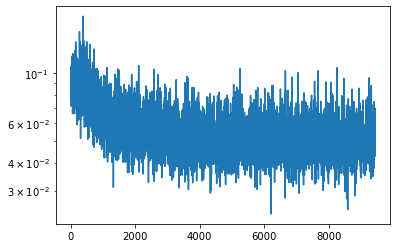

In [ ]:
losses = []
for epoch in range(epochs):
    for i, batch in enumerate(train_dataloader):

        logits = model.forward(batch[0])
        labels = batch[1].to(device)
        loss = loss_func(logits, labels.to(device))
        
        loss.backward()

        #feel lack of memory, so I use gradient accumulation
        if i % 5 == 0:
            optimizer.step()
            optimizer.zero_grad()
        
        losses.append(loss.item())

        if i % 20 == 0:
            clear_output()
            print(i)
            plt.semilogy(losses)
            plt.show()
        if (i % 300 == 0)&(i != 0):
            torch.save(model.bert_model.state_dict(), f'bert_country_encoder2.pt')